In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import sys
sys.path.append("/kaggle/input/utility-smart-meter/src")

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import our enhanced modules
from data.data_loader import load_all_raw_data
from data.data_cleaner import clean_and_merge_all_data
from features.feature_pipeline import create_comprehensive_features
from features.splitters import prepare_forecasting_data, prepare_weekahead_data

from models.xgboost_forecasting import (
    run_xgb_with_optuna
)

from evaluation.forecast_evaluation import (
    compute_forecast_metrics,
    print_split_summary,
    evaluate_model,
    evaluate_peak_performance,
    evaluate_forecast_residuals
)

from visualization.forecast_plots import (
    plot_feature_importance,
    plot_actual_vs_predicted,
    plot_peak_actual_vs_predicted
)

from sklearn.preprocessing import LabelEncoder


In [7]:
# Set the base path where all your data files and folders are located
data_path = "/kaggle/input/smart-meters-in-london"

# Call the function to load all raw datasets: consumption, household, weather, and holiday data
raw_data = load_all_raw_data(data_path)

# Extract each dataset from the returned dictionary for easier access
df_consumption = raw_data["consumption"]  # Half-hourly electricity consumption records
df_household = raw_data["household"]      # Household metadata (e.g., tariff, ACORN group)
df_weather = raw_data["weather"]          # Daily weather data
df_holiday = raw_data["holiday"]          # UK bank holiday dates

# Display the first few rows of the consumption data to confirm successful loading
df_consumption.head()

🚀 LOADING ALL RAW DATA
📂 Found 112 consumption files
✅ Loaded 3,469,352 consumption records
📂 Loading household data...
✅ Loaded 5,566 households
📂 Loading weather data...
✅ Loaded 882 weather records
📂 Loading holiday data...
✅ Loaded 25 holiday records
🎉 ALL RAW DATA LOADED


,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000047,2011-12-09,0.114,0.074,0.107,0.098,0.090,0.106,0.077,0.115,...,0.097,0.134,0.295,0.063,0.072,0.040,0.074,0.051,0.065,0.068
1,MAC000047,2011-12-10,0.035,0.082,0.050,0.064,0.059,0.048,0.082,0.044,...,0.120,0.115,0.106,0.135,0.077,0.104,0.096,0.076,0.106,0.076
2,MAC000047,2011-12-11,0.103,0.085,0.083,0.113,0.072,0.096,0.098,0.084,...,0.191,0.163,0.203,0.182,0.168,0.145,0.074,0.114,0.078,0.096
3,MAC000047,2011-12-12,0.107,0.072,0.109,0.088,0.099,0.098,0.075,0.120,...,0.160,0.195,0.156,0.105,0.125,0.076,0.111,0.074,0.098,0.104
4,MAC000047,2011-12-13,0.073,0.108,0.084,0.101,0.095,0.078,0.118,0.080,...,0.181,0.130,0.146,0.116,0.113,0.110,0.082,0.120,0.079,0.101


In [8]:
# Clean and merge all raw data
df_final = clean_and_merge_all_data(raw_data)

# View the final cleaned and enriched dataset
df_final.head()

🚀 CLEANING AND MERGING ALL DATA
🧹 Cleaning consumption data...
   ✅ Removed 0 rows with >20.0% missing
   ✅ Kept 5,556 households with ≥30 days
   🔧 Interpolating missing values...
✅ Consumption data cleaned: (3469317, 50)
🏠 Preparing household data...
✅ Household data prepared: (5566, 4)
🌤️ Preparing weather data...
   ⚠️ Found 3 dates with multiple records (likely DST transitions):
   📝 Duplicate dates: [Timestamp('2014-03-30 00:00:00'), Timestamp('2013-03-31 00:00:00'), Timestamp('2012-03-25 00:00:00')]
   📊 Counts per duplicate date:
day
2014-03-30    2
2013-03-31    2
2012-03-25    2
dtype: int64
   ✅ Removed 3 DST duplicate rows
   📊 Weather data: 882 → 879 rows
✅ Weather data prepared: (879, 6)
🎉 Preparing holiday data...
✅ Holiday data prepared: (25, 3)
🔗 Merging all datasets...
   ✅ After household merge: (3469317, 53)
   ✅ After weather merge: (3469317, 58)
   ✅ After holiday merge: (3469317, 59)
✅ All data merged successfully
📅 Adding basic temporal features...
✅ Temporal fe

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,Acorn_grouped,stdorToU,temperatureMax,temperatureMin,humidity,windSpeed,cloudCover,holiday_category,month,season
0,MAC000047,2011-12-09,0.114,0.074,0.107,0.098,0.090,0.106,0.077,0.115,...,Adversity,Std,7.68,2.03,0.71,5.65,0.15,Regular Day,12,Winter
1,MAC000047,2011-12-10,0.035,0.082,0.050,0.064,0.059,0.048,0.082,0.044,...,Adversity,Std,6.08,-0.13,0.81,3.08,0.17,Regular Day,12,Winter
2,MAC000047,2011-12-11,0.103,0.085,0.083,0.113,0.072,0.096,0.098,0.084,...,Adversity,Std,8.59,2.48,0.88,3.94,0.56,Regular Day,12,Winter
3,MAC000047,2011-12-12,0.107,0.072,0.109,0.088,0.099,0.098,0.075,0.120,...,Adversity,Std,9.82,3.09,0.84,5.02,0.38,Regular Day,12,Winter
4,MAC000047,2011-12-13,0.073,0.108,0.084,0.101,0.095,0.078,0.118,0.080,...,Adversity,Std,12.08,4.54,0.75,7.44,0.42,Regular Day,12,Winter


In [9]:
# Run the full feature pipeline
df_features = create_comprehensive_features(df_final)
df_features['household_code'] = LabelEncoder().fit_transform(df_features['LCLid'])

# Check the final DataFrame
df_features.head()

print(f"✅ Feature engineering completed:")
print(f"   📊 Total samples: {len(df_features):,}")
print(f"   📅 Date range: {df_features['day'].min()} to {df_features['day'].max()}")
print(f"   🏠 Households: {df_features['LCLid'].nunique()}")
print(f"   🔧 Features created: {len(df_features.columns)} total columns")

🚀 CREATING COMPREHENSIVE FEATURES (all features retained)
📅 Creating temporal features...
🚀 Creating All Temporal Features
📅 Creating basic temporal features...
   ✅ Created basic temporal features
🌀 Creating seasonal features...
   ✅ Created seasonal features
🎉 Creating holiday features...
   ✅ Created holiday features
⚡ Creating peak period features...
   ⚠️ peak_hour column not found
📈 Creating time trend features...
   ✅ Created time trend features
✅ All temporal features created
⚡ Creating consumption‐pattern features...
⚡ Creating consumption features...
   ✅ Created consumption features
📊 Creating consumption patterns...
   ✅ Created consumption patterns
🌤️ Creating weather features...
🚀 Creating All Weather Features
🌡️ Creating temperature features...
   ✅ Created temperature features
🌦️ Creating weather condition features...
   ✅ Created weather condition features from ['humidity', 'windSpeed', 'cloudCover']
🌡️ Creating temperature impact features...
   ✅ Created temperature i

In [11]:
def reduce_memory_footprint(df, verbose=True):
    import numpy as np
    import pandas as pd

    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f"Initial memory usage: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtypes

        if pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()

            if pd.api.types.is_integer_dtype(col_type):
                if c_min >= 0:
                    if c_max < 2**8:
                        df[col] = df[col].astype(np.uint8)
                    elif c_max < 2**16:
                        df[col] = df[col].astype(np.uint16)
                    elif c_max < 2**32:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if np.iinfo(np.int8).min < c_min < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif np.iinfo(np.int16).min < c_min < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif np.iinfo(np.int32).min < c_min < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    else:
                        df[col] = df[col].astype(np.int64)

            else:  # float
                if np.finfo(np.float16).min < c_min < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif np.finfo(np.float32).min < c_min < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

        elif col_type == object:
            num_unique = df[col].nunique()
            num_total = len(df[col])
            if num_unique / num_total < 0.5:
                df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f"Reduced memory usage: {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)")

    return df


In [12]:
df_features = reduce_memory_footprint(df_features)

Initial memory usage: 4615.74 MB
Reduced memory usage: 817.70 MB (82.3% reduction)


In [13]:
# Configuration
CONFIG = {
    'data_path': 'data',
    'test_days': 90,
    'val_days': 60,
    'forecast_scope': 'subset',  # 'single', 'subset', 'all'
    'sample_household': 'MAC000001',
    'subset_households': 400,     # list or int
    'forecast_horizon': 'both',  # 'day', 'week', or 'both'
    'use_gpu': False,
    'log_transform': True,
    'n_trials': 20,
    'seed': 42,
    'week_ahead_days' : 7
}


In [14]:
# Household selection
all_households = df_features['LCLid'].unique()
if CONFIG['forecast_scope'] == 'single':
    hh_filter = [CONFIG['sample_household']]
elif CONFIG['forecast_scope'] == 'subset':
    sh = CONFIG['subset_households']
    if isinstance(sh, int):
        np.random.seed(CONFIG['seed'])
        hh_filter = np.random.choice(all_households, size=sh, replace=True).tolist()
    elif isinstance(sh, list):
        hh_filter = sh
    else:
        raise ValueError("subset_households must be int or list")
else:
    hh_filter = all_households.tolist()

df_features = df_features[df_features['LCLid'].isin(hh_filter)]

In [15]:
# Split data
if CONFIG['forecast_horizon'] in ['day', 'both']:
    print("\n📊 Preparing day-ahead data...")
    train_df, val_df, test_df, feature_cols, target_col, _ = prepare_forecasting_data(
        df_features, target_col="total_kwh",
        test_days=CONFIG['test_days'], val_days=CONFIG['val_days']
    )
    if 'household_code' not in feature_cols:
        feature_cols.append('household_code')

    print(f"✅ Day-ahead data preparation:")
    print(f"   📈 Training samples: {len(train_df):,}")
    print(f"   🔍 Validation samples: {len(val_df):,}")
    print(f"   🎯 Test samples: {len(test_df):,}")
    print(f"   🔧 Features: {len(feature_cols)}")
    print(f"   🎯 Target: {target_col}")

if CONFIG['forecast_horizon'] in ['week', 'both']:
    print("\n📊 Preparing week-ahead data...")
    train_df7, val_df7, test_df7, feature_cols7, target_col7, _ = prepare_weekahead_data(
        df_final, df_features,
        test_days=CONFIG['test_days'], val_days=CONFIG['val_days']
    )
    if 'household_code' not in feature_cols:
        feature_cols7.append('household_code')
    print(f"✅ Week-ahead data preparation:")
    print(f"   📈 Training samples: {len(train_df7):,}")
    print(f"   🔍 Validation samples: {len(val_df7):,}")
    print(f"   🎯 Test samples: {len(test_df7):,}")
    print(f"   🔧 Features: {len(feature_cols7)}")
    print(f"   🎯 Target: {target_col7}")


📊 Preparing day-ahead data...
✅ Day‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 185,744  (Households: 380)
   ✅ Val rows:   21,177  (Households: 357)
   ✅ Test rows:  30,808  (Households: 351)
   ✅ Train period: 2011-11-24 to 2013-09-29
   ✅ Val period:   2013-09-30 to 2013-11-28
   ✅ Test period:  2013-11-29 to 2014-02-26
   ✅ Initial features (before static): 59
   ✅ Final features (including static): 62
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_1'
✅ Day-ahead data preparation:
   📈 Training samples: 185,744
   🔍 Validation samples: 21,177
   🎯 Test samples: 30,808
   🔧 Features: 62
   🎯 Target: label_1

📊 Preparing week-ahead data...
✅ Week‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 183,473  (Households: 380)
   ✅ Val rows:   21,169  (Households: 357)
   ✅ Test rows:  30,801  (Households: 351)
   ✅ Train period: 2011-11-24 to 2013-09-23
   ✅ Val period:   2013-09-24 to 2013-11-22
   ✅ Test period:  2013-11-23 to 2014-02-20
   ✅ Ini

In [16]:
# For day-ahead
print("📈 Training global day-ahead model...")
results_day = run_xgb_with_optuna(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    feature_cols=feature_cols,
    target_col="label_1",
    use_gpu=CONFIG["use_gpu"],
    log_transform=CONFIG["log_transform"],
    n_trials=CONFIG["n_trials"],
    seed=CONFIG["seed"]
)

📈 Training global day-ahead model...


  0%|          | 0/20 [00:00<?, ?it/s]


📊 OVERALL FORECAST EVALUATION
----------------------------------------
   📊 Train Performance:
      MAE:  1.9256 kWh
      RMSE: 3.5063 kWh
      MAPE: 26.79%
      R²:   0.8524
      Bias: -0.3770  (positive=overestimate, negative=underestimate)

   📊 Val Performance:
      MAE:  1.8776 kWh
      RMSE: 3.1589 kWh
      MAPE: 23.11%
      R²:   0.8322
      Bias: -0.3492  (positive=overestimate, negative=underestimate)

   📊 Test Performance:
      MAE:  2.1872 kWh
      RMSE: 3.9164 kWh
      MAPE: 51.76%
      R²:   0.8390
      Bias: -0.5922  (positive=overestimate, negative=underestimate)



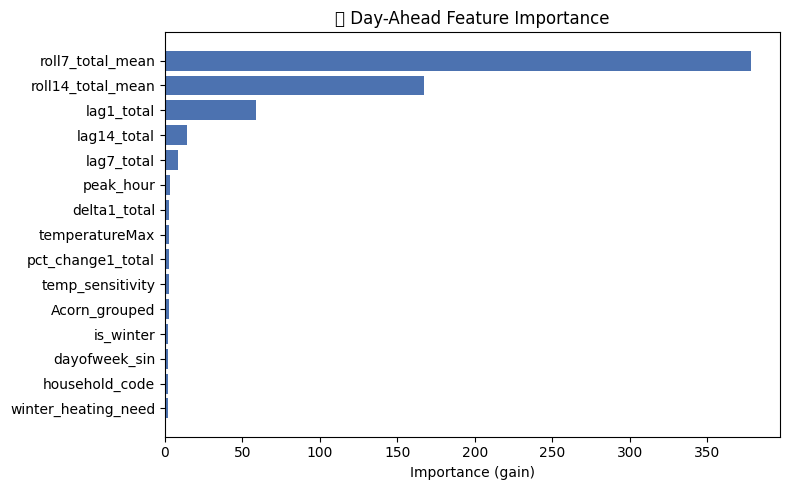

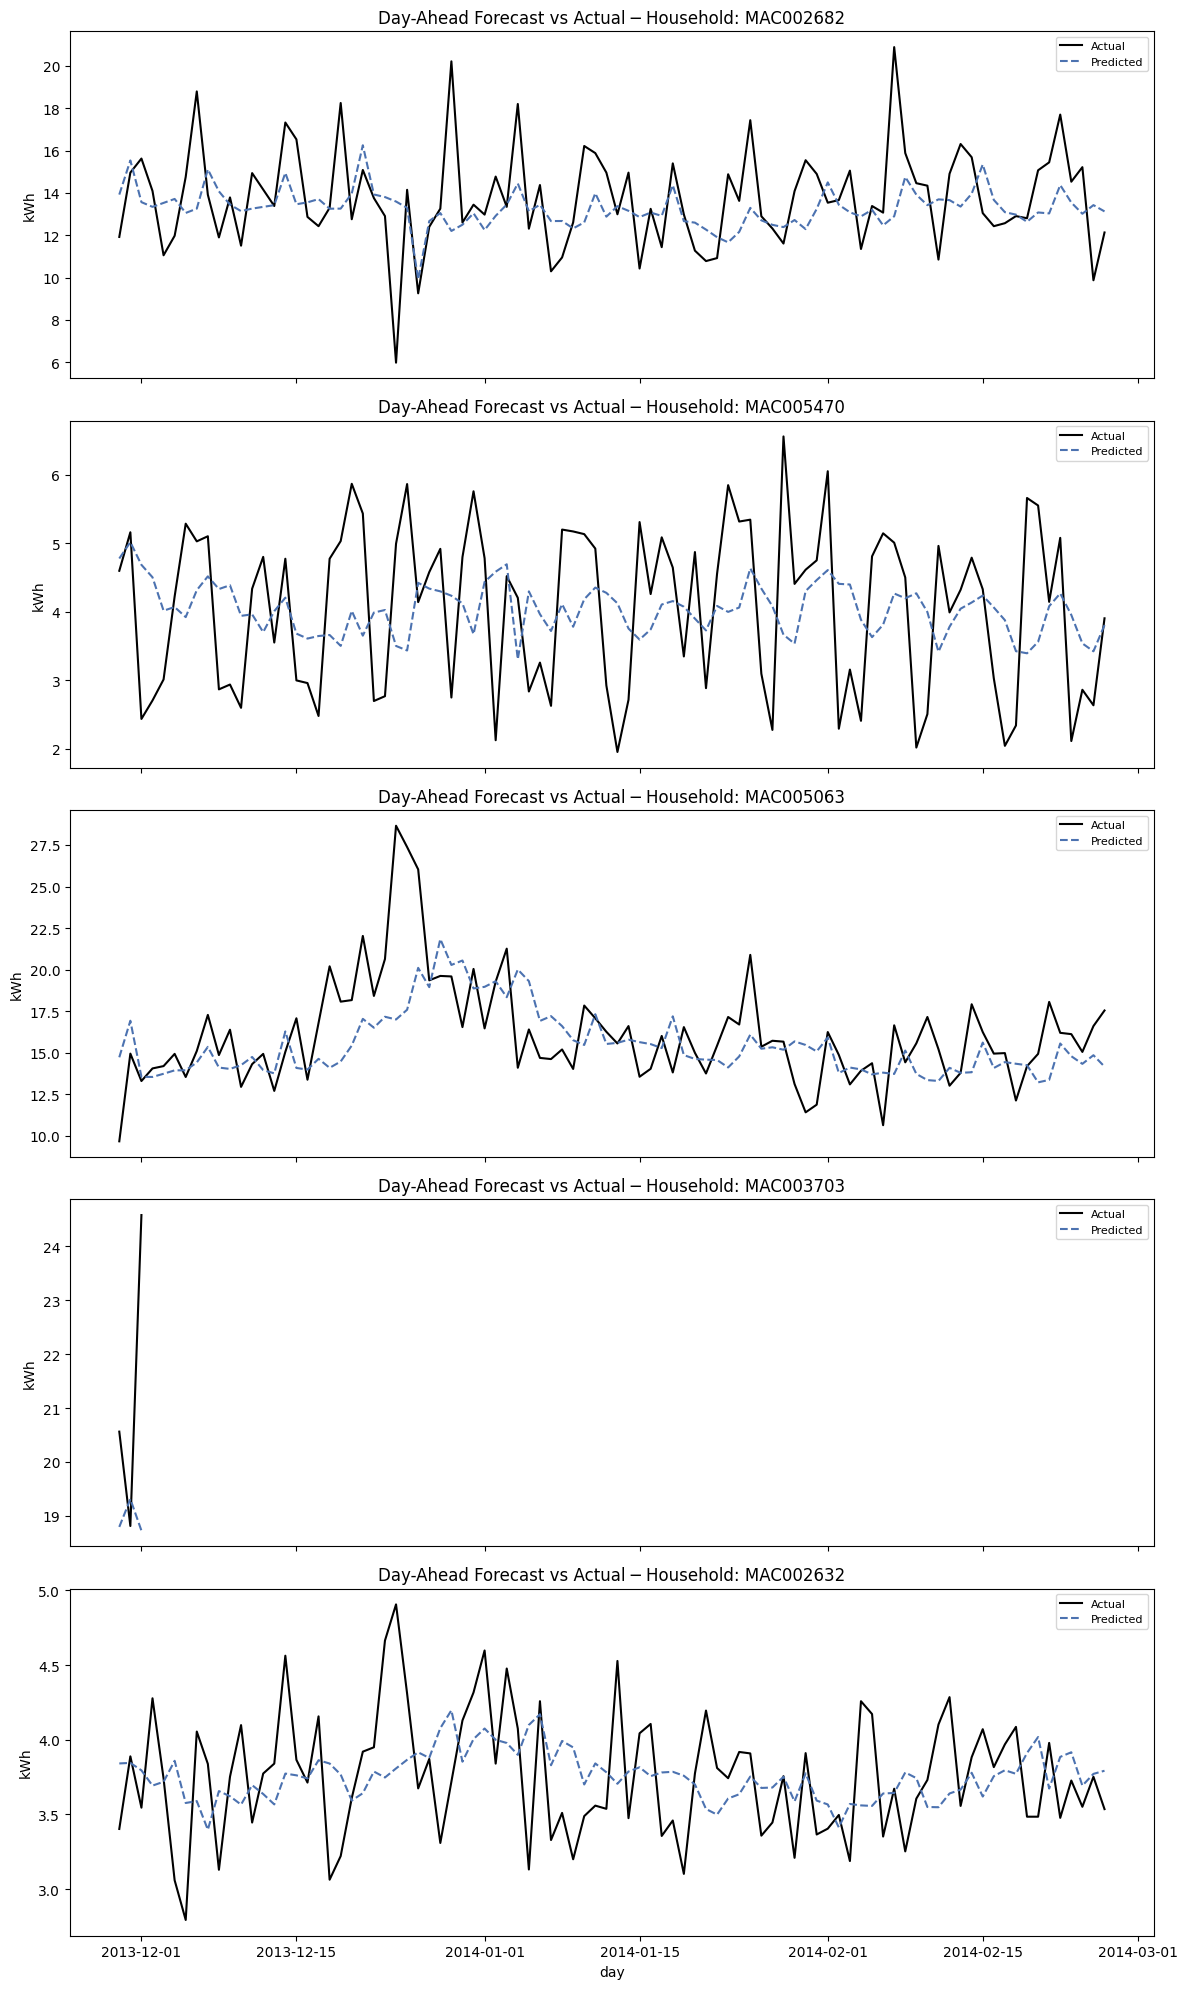

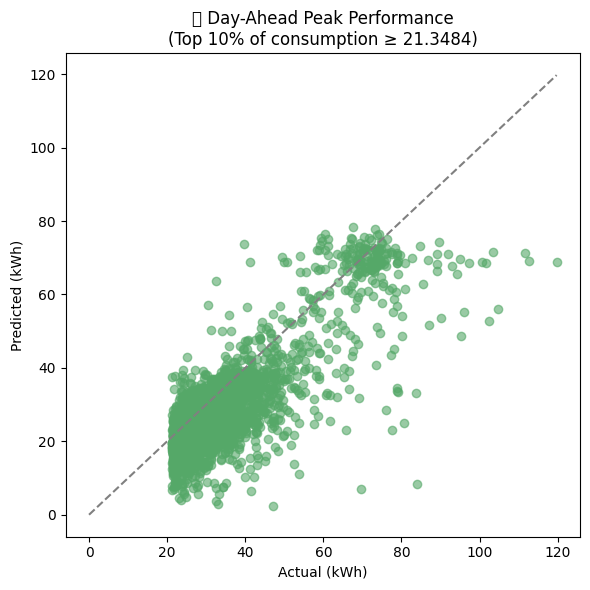

In [24]:
# Evaluate
evaluate_model(results_day)

# Peak diagnostics
# evaluate_peak_performance(
#     results_day["actuals"]["test"],
#     results_day["predictions"]["test"],
#     percentile=90
# )

# Plotting
plot_feature_importance(
    xgb_model=results_day["model"],
    feature_names=feature_cols,
    top_n=15,
    importance_type="gain",
    title="Day-Ahead Feature Importance"
)

plot_actual_vs_predicted(
    df_test=test_df,
    date_col="day",
    id_col="LCLid",
    target_col="label_1",
    y_pred=results_day["predictions"]["test"],
    sample_n=5,
    title_prefix="Day-Ahead Forecast vs Actual"
)


plot_peak_actual_vs_predicted(
    df_test=test_df,
    target_col="label_1",
    y_pred=results_day["predictions"]["test"],
    percentile=90,
    title="Day-Ahead Peak Performance"
)

In [25]:
# For week-ahead
print("📈 Training global week-ahead model...")
results_week = run_xgb_with_optuna(
    train_df=train_df7,
    val_df=val_df7,
    test_df=test_df7,
    feature_cols=feature_cols7,
    target_col="label_7",  # weekly target column
    use_gpu=CONFIG["use_gpu"],
    log_transform=CONFIG["log_transform"],
    n_trials=CONFIG["n_trials"],
    seed=CONFIG["seed"]
)

📈 Training global week-ahead model...


  0%|          | 0/20 [00:00<?, ?it/s]


📊 OVERALL FORECAST EVALUATION
----------------------------------------
   📊 Train Performance:
      MAE:  2.2898 kWh
      RMSE: 4.3464 kWh
      MAPE: 44.33%
      R²:   0.7732
      Bias: -0.5720  (positive=overestimate, negative=underestimate)

   📊 Val Performance:
      MAE:  2.1998 kWh
      RMSE: 3.8622 kWh
      MAPE: 32.10%
      R²:   0.7486
      Bias: -0.6062  (positive=overestimate, negative=underestimate)

   📊 Test Performance:
      MAE:  2.5531 kWh
      RMSE: 4.8335 kWh
      MAPE: 172.07%
      R²:   0.7546
      Bias: -0.6461  (positive=overestimate, negative=underestimate)



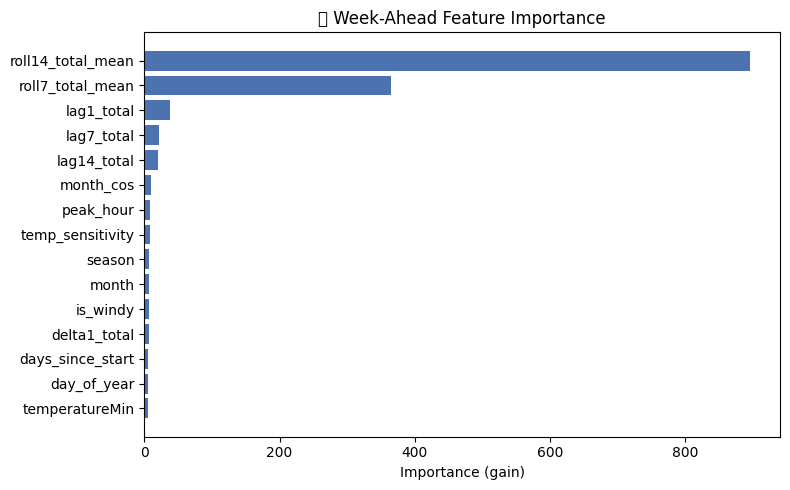

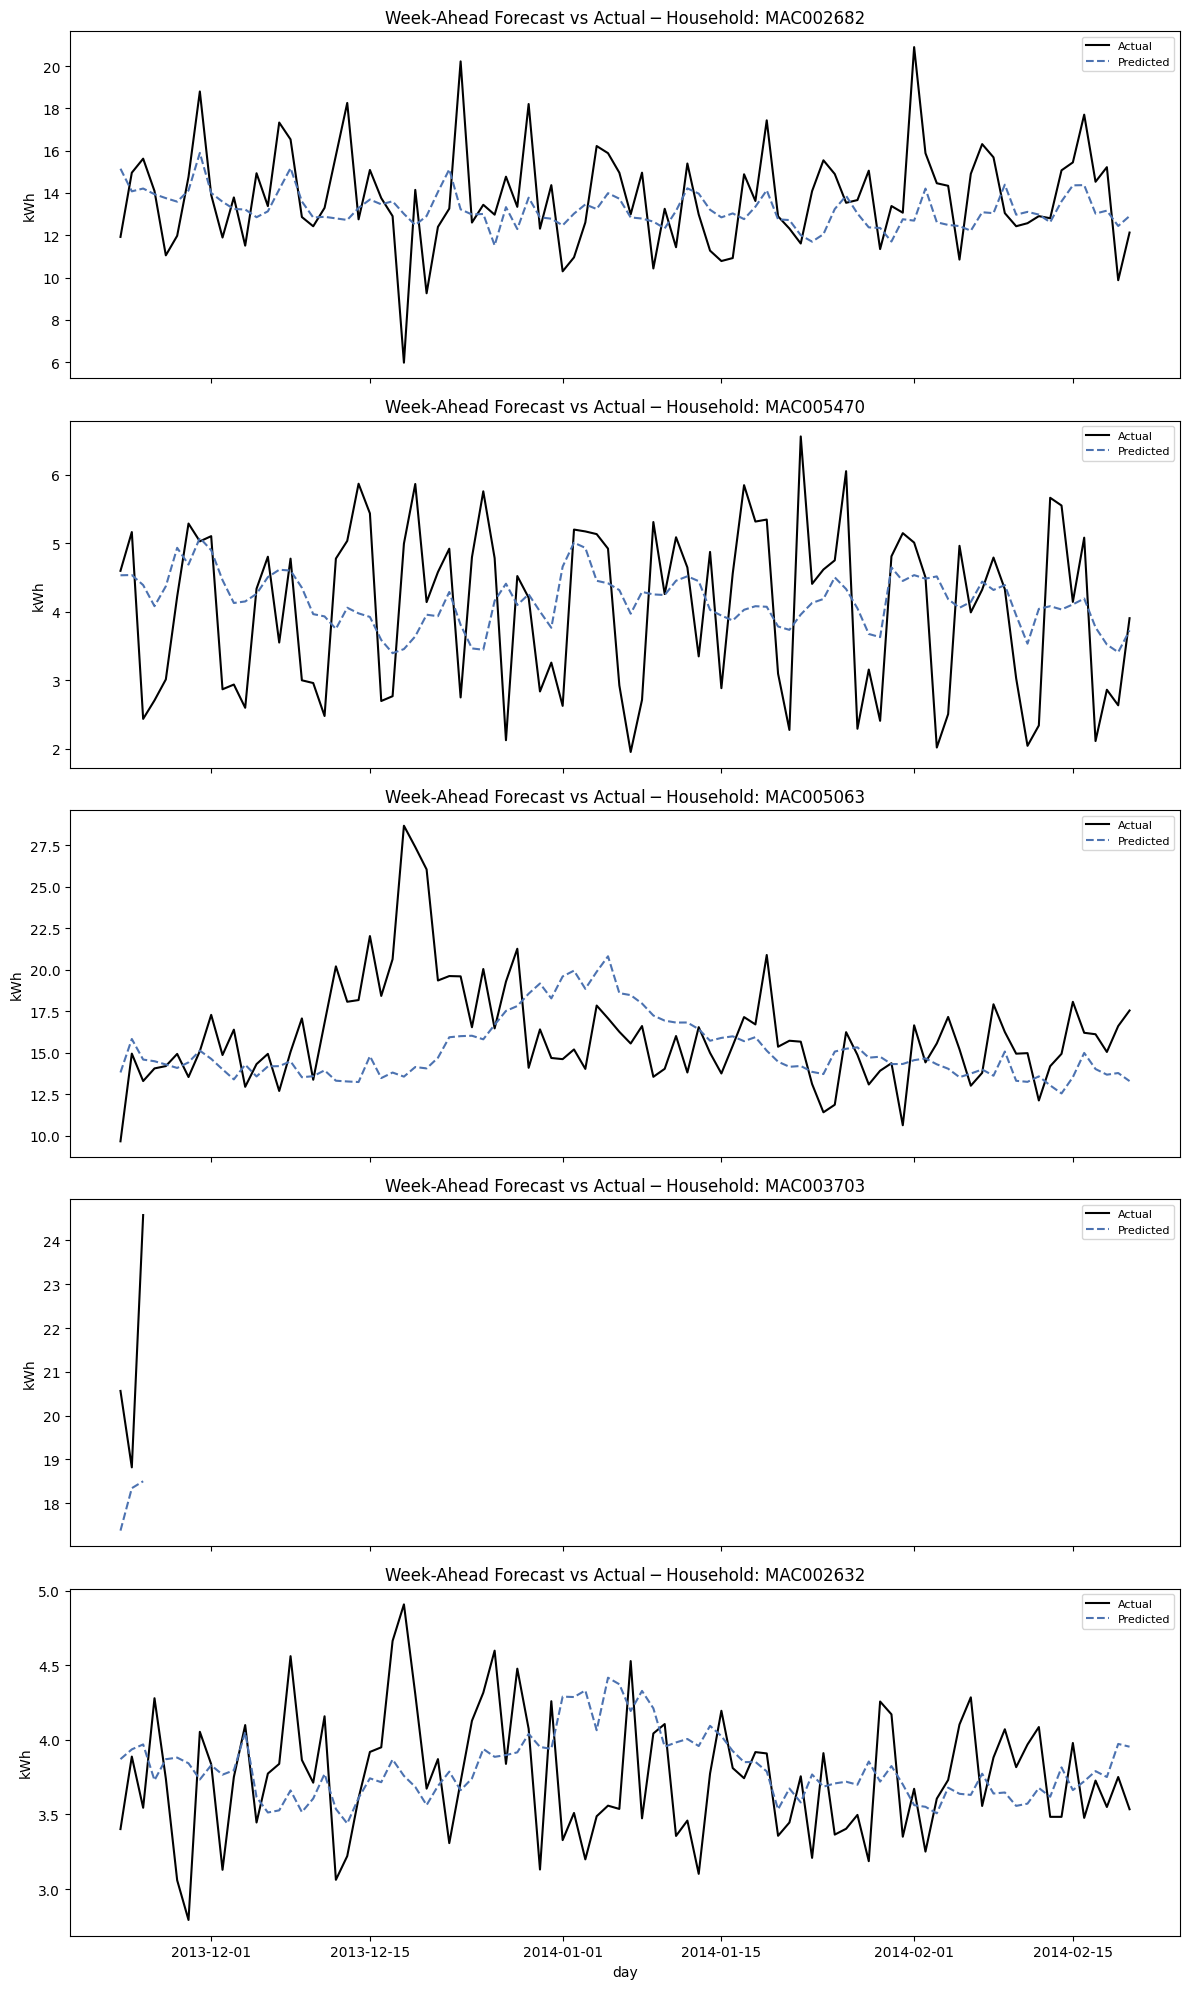

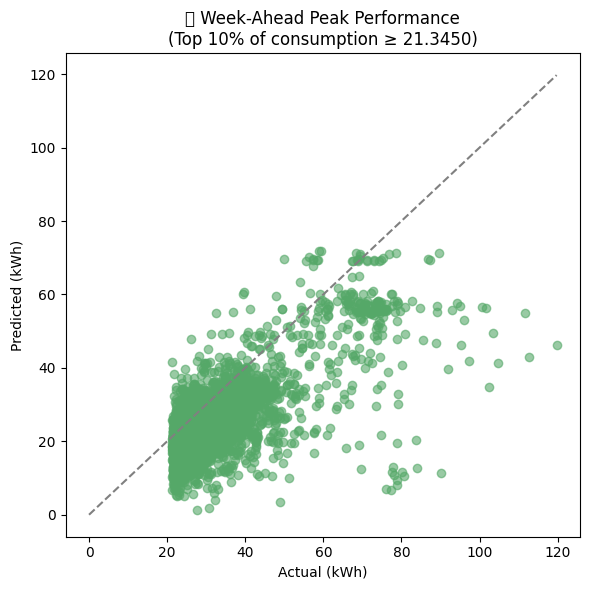

In [26]:
# Evaluate
evaluate_model(results_week)

# Peak diagnostics
# evaluate_peak_performance(
#     results_day["actuals"]["test"],
#     results_day["predictions"]["test"],
#     percentile=90
# )

# Plotting
plot_feature_importance(
    xgb_model=results_week["model"],
    feature_names=feature_cols7,
    top_n=15,
    importance_type="gain",
    title="Week-Ahead Feature Importance"
)

plot_actual_vs_predicted(
    df_test=test_df7,
    date_col="day",
    id_col="LCLid",
    target_col="label_7",
    y_pred=results_week["predictions"]["test"],
    sample_n=5,
    title_prefix="Week-Ahead Forecast vs Actual"
)


plot_peak_actual_vs_predicted(
    df_test=test_df7,
    target_col="label_7",
    y_pred=results_week["predictions"]["test"],
    percentile=90,
    title="Week-Ahead Peak Performance"
)